# Variant file

In [1]:
from collections import defaultdict
from pprint import pprint

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import pysam
from pysam import VariantFile
import seaborn as sns

from analysis import collect_fragment_sizes, pool_variant_fragment_sizes

In [3]:
pd.DataFrame([dict(variant.info.items()[:9]) for variant in variants.fetch()])
#     pprint(variant.info.items()[:9])

,AF,ALTDP,ALTDP2,DP,DP2,NGED,SCORE1,SID,SS
0,"(0.7912189960479736,)",4415,649,5580,827,"(0.008742369711399078,)",4409.000000,972_0,True
1,"(0.0014419599901884794,)",12,2,8322,1434,"(0.010326500050723553,)",4.000000,972_0,True
2,"(0.5526139736175537,)",4842,887,8762,1629,"(0.012241500429809093,)",4835.490234,972_0,True
3,"(0.4695169925689697,)",3250,529,6922,1135,"(0.008843899704515934,)",3242.000000,972_0,True


In [4]:
annotation_columns = variants.header \
    .info['ANN'] \
    .description \
    .split(':')[1] \
    .replace("'", "") \
    .split('|')
annotation_columns = tuple(map(lambda x: x.strip(), annotation_columns))

In [5]:
record = next(variants.fetch())
df = pd.DataFrame(columns=annotation_columns)
for annotation in record.info['ANN']:
    key_value_pairs = zip(annotation_columns, annotation.split('|'))
    df = df.append(dict(key_value_pairs), ignore_index=True)
df

,Allele,Annotation,Annotation_Impact,Gene_Name,Gene_ID,Feature_Type,Feature_ID,Transcript_BioType,Rank,HGVS.c,HGVS.p,cDNA.pos / cDNA.length,CDS.pos / CDS.length,AA.pos / AA.length,Distance,ERRORS / WARNINGS / INFO
0,A,stop_gained,HIGH,TP53,ENSG00000141510,transcript,ENST00000269305.8,protein_coding,8/11,c.892G>T,p.Glu298*,1082/2579,892/1182,298/393,,
1,A,stop_gained,HIGH,TP53,ENSG00000141510,transcript,ENST00000420246.6,protein_coding,8/12,c.892G>T,p.Glu298*,1025/2653,892/1026,298/341,,
2,A,stop_gained,HIGH,TP53,ENSG00000141510,transcript,ENST00000455263.6,protein_coding,8/12,c.892G>T,p.Glu298*,1025/2580,892/1041,298/346,,
3,A,stop_gained,HIGH,TP53,ENSG00000141510,transcript,ENST00000615910.4,protein_coding,8/11,c.859G>T,p.Glu287*,859/1149,859/1149,287/382,,


In [6]:
record.info.items()[:9]

[('AF', (0.7912189960479736,)),
 ('ALTDP', 4415),
 ('ALTDP2', 649),
 ('DP', 5580),
 ('DP2', 827),
 ('NGED', (0.008742369711399078,)),
 ('SCORE1', 4409.0),
 ('SID', '972_0'),
 ('SS', True)]

# Reading BAM file

In [10]:
variants = VariantFile('data/snv-Somatic_all-972_0.vcf')
alignments = pysam.AlignmentFile('data/Deduped-972_0_sorted.bam')

In [11]:
normal_sizes, variant_sizes = pool_variant_fragment_sizes(
    variant_file=variants, 
    bam_file=alignments,
)

Collect fragment sizes for chr17 7673727 7673728
VAF(A) 3.768987341772152
Collect fragment sizes for chr17 58357955 58357956
VAF(A) 0.0013415615776764154
Collect fragment sizes for chr4 54274526 54274527
VAF(T) 1.2589712918660287
Collect fragment sizes for chr9 95459699 95459700
VAF(A) 0.9145780051150895


In [46]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = '{:.1f}'.format(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
percent_formatter = FuncFormatter(to_percent)

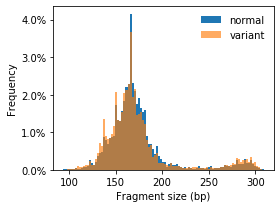

In [49]:
plt.figure(figsize=(4,3))
p_normal, bins, _ = plt.hist(
    normal_sizes, 
    bins=100, 
    density=True, 
    label='normal',
    alpha=1.0,
)
p_variant, _, _ = plt.hist(
    variant_sizes, 
    density=True, 
    bins=bins, 
    label='variant',
    alpha=0.65,
)
plt.legend(frameon=False)
plt.xlabel('Fragment size (bp)')
plt.ylabel('Frequency')
plt.gca().yaxis.set_major_formatter(percent_formatter)
plt.tight_layout()
plt.savefig('figs/fragment_distribution.png')

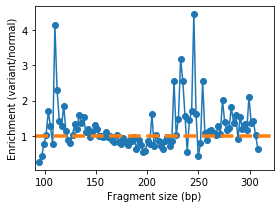

In [50]:
plt.figure(figsize=(4,3))
with np.errstate(divide='ignore'):
    enrichment = p_variant/p_normal
    enrichment[np.isnan(enrichment)] = 0
bin_centre = (bins[1:] + bins[:-1])/2.0
plt.plot(bin_centre, enrichment, '-o')
horizontal_window = (0.95*bin_centre[0], bin_centre[-1]*1.05)
plt.plot(horizontal_window, (1, 1), '--', linewidth=3.5)
plt.xlim(horizontal_window)
plt.xlabel('Fragment size (bp)')
plt.ylabel('Enrichment (variant/normal)')
plt.tight_layout()
plt.savefig('figs/enrichment.png')